In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
cur_path = "/content/gdrive/MyDrive/final_project/"
os.chdir(cur_path)
!pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/final_project


In [ ]:
import pandas as pd
import numpy as np

### feature

In [ ]:
feature = pd.read_csv('final_df.csv')

In [ ]:
feature.shape

(295972, 41)

In [ ]:
feature.head()

,Unnamed: 0,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange,intake_back,post_back,comment_back,spend_back,order_back,max_date,weight_loss_max,label
0,317,26,2013-05-31,0,2,162.0,52.0,596,0.0,0.0,0.0,28,0,0,0,1,1,1987-05-02,NaN,56.0,2013-12-12,62.0,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,62.0,2014-03-23,2014-03-27,29,870.400000,2.315757,4.156579,42.087528,2.188645,2014-03-23,6.0,1.0
1,330,474,2013-06-01,0,1,175.0,72.0,596,0.0,0.0,0.0,29,0,0,0,1,1,1986-10-08,NaN,79.0,2013-12-31,75.0,0.00,2013-10-01 07:24:56,1112.864586,1.659943,3.135706,23.333333,3.000000,75.0,2013-11-26,2014-09-21,29,1112.864586,1.659943,3.135706,23.333333,3.000000,2013-11-26,-4.0,0.0
2,348,964,2013-06-02,0,2,170.0,52.5,596,0.0,0.0,0.0,20,0,0,0,1,1,1995-11-03,NaN,55.0,2014-05-01,60.7,19.03,2013-10-01 07:32:15,1012.210526,2.221127,4.031142,36.091155,2.551160,60.7,2014-10-05,2014-10-15,19,1012.210526,2.221127,4.031142,36.091155,2.551160,2014-10-05,5.7,1.0
3,361,1677,2013-06-03,0,2,164.0,50.0,596,0.0,0.0,0.0,32,0,0,0,1,1,1983-06-10,NaN,55.0,2013-04-01,55.0,0.00,2013-10-01 07:50:38,1310.538462,3.210461,5.653811,36.346078,2.904192,55.0,2014-02-08,2014-02-08,39,1310.538462,3.210461,5.653811,36.346078,2.904192,2014-02-08,0.0,0.0
4,387,2529,2013-05-31,1,1,172.0,65.0,596,0.0,0.0,0.0,33,0,0,0,1,1,1982-10-11,NaN,90.0,2013-12-12,81.2,30.42,2013-10-01 08:13:36,1785.263547,2.126627,3.210011,38.580000,3.400000,81.2,2014-05-09,2014-07-21,39,1785.263547,2.126627,3.210011,38.580000,3.400000,2014-05-09,-8.8,0.0


In [ ]:
node = list(feature.user_id)

In [ ]:
feature.shape

(295972, 41)

In [ ]:
feature['new_label'] = feature['weight_loss_max'].apply(lambda x: 1 if x<0 else 0)

In [ ]:
feature.new_label.mean()

0.5283979565634587

In [ ]:
feature.lastdays.mean()

432.9078493911586

### friend

In [ ]:
friend = pd.read_csv('WeightLoss/network/friend_consolidated.csv')

In [ ]:
friend.head()

,user_id,follower_id,date
0,121,143,2013-09-30
1,121,166,2013-09-30
2,143,33,2013-09-30
3,33,143,2013-09-30
4,166,143,2013-09-30


In [ ]:
friend['date'] = pd.to_datetime(friend['date'])  

In [ ]:
friend.head()

,user_id,follower_id,date
0,121,143,2013-09-30
1,121,166,2013-09-30
2,143,33,2013-09-30
3,33,143,2013-09-30
4,166,143,2013-09-30


In [ ]:
friend_filter = friend[friend.user_id.isin(node) & friend.follower_id.isin(node)]

In [ ]:
friend_final = friend_filter[friend_filter['date'] <= '2014-01-01']

In [ ]:
friend_filter.shape

(2552582, 3)

In [ ]:
friend_final.shape

(1002676, 3)

NetworkX

In [ ]:
import networkx as nx
Graphtype = nx.DiGraph()
G = nx.from_pandas_edgelist(friend_final, create_using=Graphtype,source='user_id',target='follower_id')

In [ ]:
import networkx as nx
Graphtype = nx.DiGraph()
G = nx.from_pandas_edgelist(friend_filter, create_using=Graphtype,source='user_id',target='follower_id')

In [ ]:
print(G.number_of_nodes())
print(G.number_of_edges())

163278
2552582


In [ ]:
node_list = list(G.nodes())

In [ ]:
len(node_list)

163278

In [ ]:
remove = [node for node,degree in dict(G.degree()).items() if degree <5]

In [ ]:
G.remove_nodes_from(remove)

In [ ]:
node_list = list(G.nodes())
len(node_list)

104006


### Extract feature

In [ ]:
feature = feature.set_index('user_id')

In [ ]:
feature = feature.reindex(node_list)

In [ ]:
feature.columns

Index(['Unnamed: 0', 'cutoff', 'avatar', 'gendar', 'height', 'target_weight',
       'lastdays', 'AvgPost', 'AvgComment', 'AvgMention', 'age', 'hasPost',
       'hasComment', 'hasMention', 'hasHeight', 'hasWeightTarget', 'birthday',
       'location', 'weight_x', 'target_date', 'latest_weight', 'bmi',
       'created_at', 'calory_intake_freq', 'daily_post_count',
       'daily_comment_count', 'spend_per_order', 'order_counts', 'weight_y',
       'record_on', 'date', 'agerange', 'intake_back', 'post_back',
       'comment_back', 'spend_back', 'order_back', 'max_date',
       'weight_loss_max', 'label', 'new_label'],
      dtype='object')

In [ ]:
feature.to_csv('feature.csv')

In [ ]:
fe = feature[['gendar','age','bmi','weight_x',
              'calory_intake_freq','daily_post_count','daily_comment_count',
              'AvgPost', 'AvgComment', 'AvgMention',
              'spend_per_order','order_counts',
              'hasWeightTarget']]

In [ ]:
fe = feature[['gendar','age','bmi','weight_x',
              'hasWeightTarget',
              'AvgPost', 'AvgComment', 'AvgMention']]

In [ ]:
fe.head()

,gendar,age,bmi,weight_x,hasWeightTarget,AvgPost,AvgComment,AvgMention
user_id,,,,,,,,
121,1,26,26.73,80.0,1,0.309,0.619,0.413
143,1,32,27.92,76.0,1,0.042,0.067,0.037
98119,2,32,25.39,65.0,1,0.129,0.348,0.073
139824,2,28,21.94,61.2,1,0.024,0.009,0.000
150458,2,19,23.15,60.0,1,0.106,0.050,0.014


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform(fe) 

In [ ]:
arr_scaled.shape

(104006, 8)

In [ ]:
fe = np.array(fe)

In [ ]:
fe.shape

(104006, 8)

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 4.4MB/s 
     |████████████████████████████████| 1.5MB 4.6MB/s 
     |████████████████████████████████| 215kB 6.5MB/s 
     |████████████████████████████████| 235kB 9.0MB/s 
     |████████████████████████████████| 2.2MB 10.3MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 


In [ ]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack
import scipy.sparse
import networkx as nx

import torch_geometric.data


In [ ]:
test = torch_geometric.utils.convert.from_networkx(G)

In [ ]:
test

Data(edge_index=[2, 2426793])

In [ ]:
test.edge_index

tensor([[     0,      0,      0,  ..., 104001, 104001, 104001],
        [     1,      2,      4,  ...,  46268,  78976,  61377]])

In [ ]:
x = torch.tensor(fe, dtype=torch.float)

In [ ]:
x = torch.tensor(arr_scaled, dtype=torch.float)

In [ ]:
test.x = x

In [ ]:
test

Data(edge_index=[2, 2426793], x=[104006, 8])

In [ ]:
test.is_directed()

True

In [ ]:
label = feature.new_label.values

In [ ]:
label.shape

(104006,)

In [ ]:
sum(label)

58528

In [ ]:
test.y = torch.tensor(label,dtype=torch.long)

In [ ]:
test.train_mask = torch.tensor([1]*72804+[0]*31202, dtype=torch.bool)
test.test_mask = torch.tensor([0]*72804+[1]*15601+[0]*15601, dtype=torch.bool)
test.val_mask = torch.tensor([0]*72804 + [1]*31202, dtype=torch.bool)

In [ ]:
label[-15601:].mean()

0.6303442087045702

In [ ]:
#test.y = torch.tensor([1,0,1,1,1,0,1,0], dtype=torch.long)
#test.train_mask = torch.tensor([1,1,1,0,0,0,0,0], dtype=torch.bool)
#test.val_mask = torch.tensor([0,0,0,1,1,0,0,0], dtype=torch.bool)
#test.test_mask = torch.tensor([0,0,0,0,0,1,1,1], dtype=torch.bool)

In [ ]:
test

Data(edge_index=[2, 2426793], test_mask=[104006], train_mask=[104006], val_mask=[104006], x=[104006, 8], y=[104006])

In [ ]:
test.num_node_features

8

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SGConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SGConv(
            test.num_features, 2, K=5, cached=True)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), test.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


best_val_acc = test_acc = 0
for epoch in range(1, 101):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, train_acc, best_val_acc, test_acc))

Epoch: 001, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 002, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 003, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 004, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 005, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 006, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 007, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 008, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 009, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 010, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 011, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 012, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 013, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 014, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 015, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 016, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 017, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 018, Train: 0.4533, Val: 0.3997, Test: 0.4298
Epoch: 019, Train: 0.4533, Val: 0.3997, Test: 

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(test.num_node_features, 512)
        self.conv2 = GCNConv(512, 512)
        self.conv3 = GCNConv(512, 2)
        #self.conv4 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        #x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        #x = self.conv4(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = test.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

model.train()
for epoch in range(1):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
acc = correct / int(data.val_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = pred[data.test_mask].cpu().data.numpy()

In [ ]:
y_true = data.y[data.test_mask].cpu().data.numpy()

In [ ]:
cm = confusion_matrix(y_true, y_pred)

In [ ]:
cm

array([[6705,    0],
       [8896,    0]])

Confusion matrix, without normalization
[[   0 6705]
 [   0 8896]]


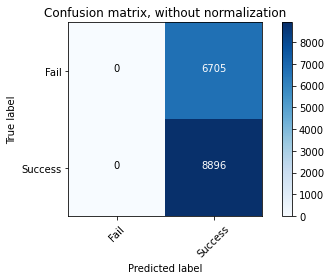

In [ ]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


#Assumming that your predicted results are in csv. If not, you can still modify the example to suit your requirements

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm,classes=['Fail','Success'],
                      title='Confusion matrix, without normalization')

In [ ]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()

precision = tp / tp_and_fp
recall = tp / tp_and_fn

In [ ]:
tp

array([   4, 3256])

In [ ]:
precision

array([0.57142857, 0.50677043])

In [ ]:
recall

array([0.00126064, 0.99907947])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.00      0.00      3173
           1       0.51      1.00      0.67      3259

    accuracy                           0.51      6432
   macro avg       0.48      0.50      0.34      6432
weighted avg       0.48      0.51      0.34      6432



In [ ]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average='weighted')

0.5065298507462687

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average='weighted')

0.4843811064096632

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='binary')

0.6720396776193428